# Preferential Bayesian Optimization: Predictive Entropy Search
This notebook demonstrates the use of the Predictive Entropy Search (PES) acquisition function on ordinal (preference) data. 

Formulation by Nguyen Quoc Phong.

In [1]:
import numpy as np
import gpflow
import tensorflow as tf
import matplotlib.pyplot as plt
import sys
import os
import pickle

from gpflow.utilities import set_trainable, print_summary
gpflow.config.set_default_summary_fmt("notebook")

sys.path.append(os.path.split(os.path.split(os.path.split(os.getcwd())[0])[0])[0]) # Move 3 levels up directory to import PBO
import PBO

In [2]:
objective = PBO.objectives.six_hump_camel
objective_low = -1.5
objective_high = 1.5
objective_name = "SHC"
acquisition_name = "PES"
experiment_name = "PBO" + "_" + acquisition_name + "_" + objective_name

In [3]:
num_runs = 20
num_evals = 20
num_samples = 100
num_choices = 2
input_dims = 2
num_maximizers = 20
num_init_points = 3
num_inducing_init = 3
num_discrete_per_dim = 1000 # Discretization of continuous input space

In [4]:
results_dir = os.getcwd() + '/results/' + experiment_name + '/'

try:
    # Create target Directory
    os.makedirs(results_dir)
    print("Directory " , results_dir ,  " created ") 
except FileExistsError:
    print("Directory " , results_dir ,  " already exists")

Directory  /home/sebtsh/PBO/notebooks/PES/results/PBO_PES_SHC/  already exists


Plot of the SHC function (global min at at x = [0.0898, -0.7126] and x = [-0.0898, 0.7126]):

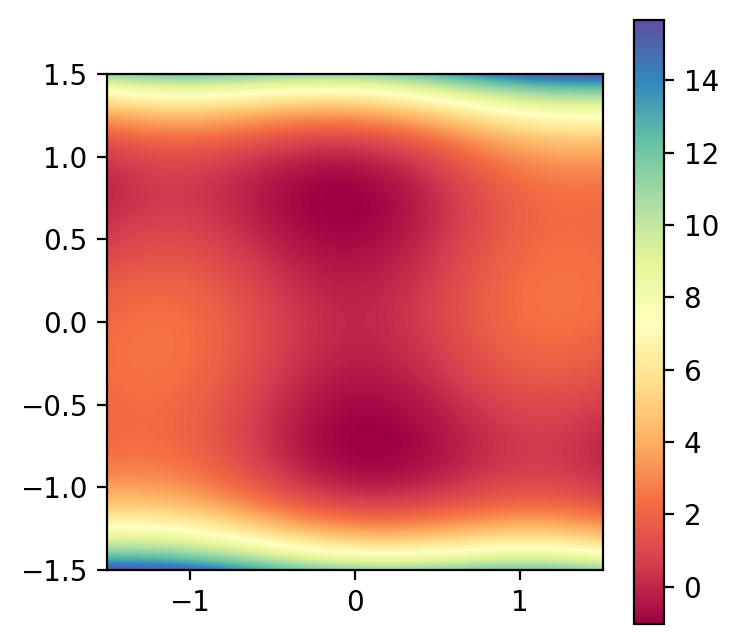

In [5]:
side = np.linspace(objective_low, objective_high, num_discrete_per_dim)
X,Y = np.meshgrid(side,side)
combs = PBO.acquisitions.dts.combinations(np.expand_dims(side, axis=1))
fvals = objective(combs)
preds = tf.transpose(tf.reshape(fvals, [num_discrete_per_dim, num_discrete_per_dim]))
plt.figure(figsize=(4, 4), dpi=200)
plt.imshow(preds, 
           interpolation='nearest', 
           extent=(objective_low, objective_high, objective_low, objective_high), 
           origin='lower', 
           cmap='Spectral')
plt.colorbar()

In [6]:
def plot_gp(model, inducing_points, inputs, title, cmap="Spectral"):

    side = np.linspace(objective_low, objective_high, num_discrete_per_dim)
    combs = PBO.acquisitions.dts.combinations(np.expand_dims(side, axis=1))
    predictions = model.predict_y(combs)
    preds = tf.transpose(tf.reshape(predictions[0], [num_discrete_per_dim, num_discrete_per_dim]))
    variances = tf.transpose(tf.reshape(predictions[1], [num_discrete_per_dim, num_discrete_per_dim]))

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    fig.set_size_inches(18.5, 6.88)
    fig.set_dpi((200))

    ax1.axis('equal')
    im1 = ax1.imshow(preds, 
                     interpolation='nearest', 
                     extent=(objective_low, objective_high, objective_low, objective_high), 
                     origin='lower', 
                     cmap=cmap)
    ax1.plot(inducing_points[:, 0], inducing_points[:, 1], 'kx', mew=2)
    ax1.plot(inputs[:, 0], inputs[:, 1], 'ko', mew=2, color='w')
    ax1.set_title("Mean")
    ax1.set_xlabel("x0")
    ax1.set_ylabel("x1")
    fig.colorbar(im1, ax=ax1)

    ax2.axis('equal')
    im2 = ax2.imshow(variances, 
                     interpolation='nearest', 
                     extent=(objective_low, objective_high, objective_low, objective_high), 
                     origin='lower', 
                     cmap=cmap)
    ax2.plot(inducing_points[:, 0], inducing_points[:, 1], 'kx', mew=2)
    ax2.plot(inputs[:, 0], inputs[:, 1], 'ko', mew=2, color='w')
    ax2.set_title("Variance")
    ax2.set_xlabel("x0")
    ax2.set_ylabel("x1")
    fig.colorbar(im2, ax=ax2)

    plt.savefig(fname=results_dir + title + ".png")
    plt.show()

In [7]:
def get_noisy_observation(X, objective):
    f = PBO.objectives.objective_get_f_neg(X, objective)
    return PBO.observation_model.gen_observation_from_f(X, f, 1)

In [8]:
def train_and_visualize(X, y, num_inducing, title):
    
    # Train model with data
    q_mu, q_sqrt, u, inputs, k, indifference_threshold = PBO.models.learning_stochastic.train_model_fullcov(X, y, 
                                                                         num_inducing=num_inducing,
                                                                         obj_low=objective_low,
                                                                         obj_high=objective_high,
                                                                         num_steps=30) # TODO CHANGE!!
    likelihood = gpflow.likelihoods.Gaussian()
    model = PBO.models.learning.init_SVGP_fullcov(q_mu, q_sqrt, u, k, likelihood)
    u_mean = q_mu.numpy()
    inducing_vars = u.numpy()
    
    # Visualize model
    plot_gp(model, inducing_vars, inputs, title)
    
    return model, inputs, u_mean, inducing_vars

In [9]:
def uniform_grid(input_dims, num_discrete_per_dim, low=0., high=1.):
    """
    Returns an array with all possible permutations of discrete values in input_dims number of dimensions.
    :param input_dims: int
    :param num_discrete_per_dim: int
    :param low: int
    :param high: int
    :return: tensor of shape (num_discrete_per_dim ** input_dims, input_dims)
    """
    num_points = num_discrete_per_dim ** input_dims
    out = np.zeros([num_points, input_dims])
    discrete_points = np.linspace(low, high, num_discrete_per_dim)
    for i in range(num_points):
        for dim in range(input_dims):
            val = num_discrete_per_dim ** (dim)
            out[i, dim] = discrete_points[int((i // val) % num_discrete_per_dim)]
    return out

This function is our main metric for the performance of the acquisition function: The closer the model's best guess to the global minimum, the better.

In [10]:
def best_guess(model):
    """
    Returns a GP model's best guess of the global maximum of f.
    """
    xx = uniform_grid(input_dims, num_discrete_per_dim, low=objective_low, high=objective_high)
    res = model.predict_f(xx)[0].numpy()
    return xx[np.argmax(res)]

Store the results in these arrays:

In [11]:
num_data_at_end = int((num_init_points-1) * num_init_points / 2 + num_evals)
X_results = np.zeros([num_runs, num_data_at_end, num_choices, input_dims])
y_results = np.zeros([num_runs, num_data_at_end, input_dims])
best_guess_results = np.zeros([num_runs, num_evals, input_dims])

Create the initial values for each run:

In [12]:
np.random.seed(0)
init_points = np.random.uniform(low=objective_low, high=objective_high, size=[num_runs, num_init_points, input_dims])
num_combs = int((num_init_points-1) * num_init_points / 2)
init_vals = np.zeros([num_runs, num_combs, num_choices, input_dims])
for run in range(num_runs):
    cur_idx = 0
    for init_point in range(num_init_points-1):
        for next_point in range(init_point+1, num_init_points):
            init_vals[run, cur_idx, 0] = init_points[run, init_point]
            init_vals[run, cur_idx, 1] = init_points[run, next_point]
            cur_idx += 1

In [13]:
X = init_vals[0]
y = get_noisy_observation(X, objective)

Indifference_threshold is trainable.
Instructions for updating:
Use tf.identity instead.
Negative ELBO at step 0: 2.980399863916467 in 0.2859s


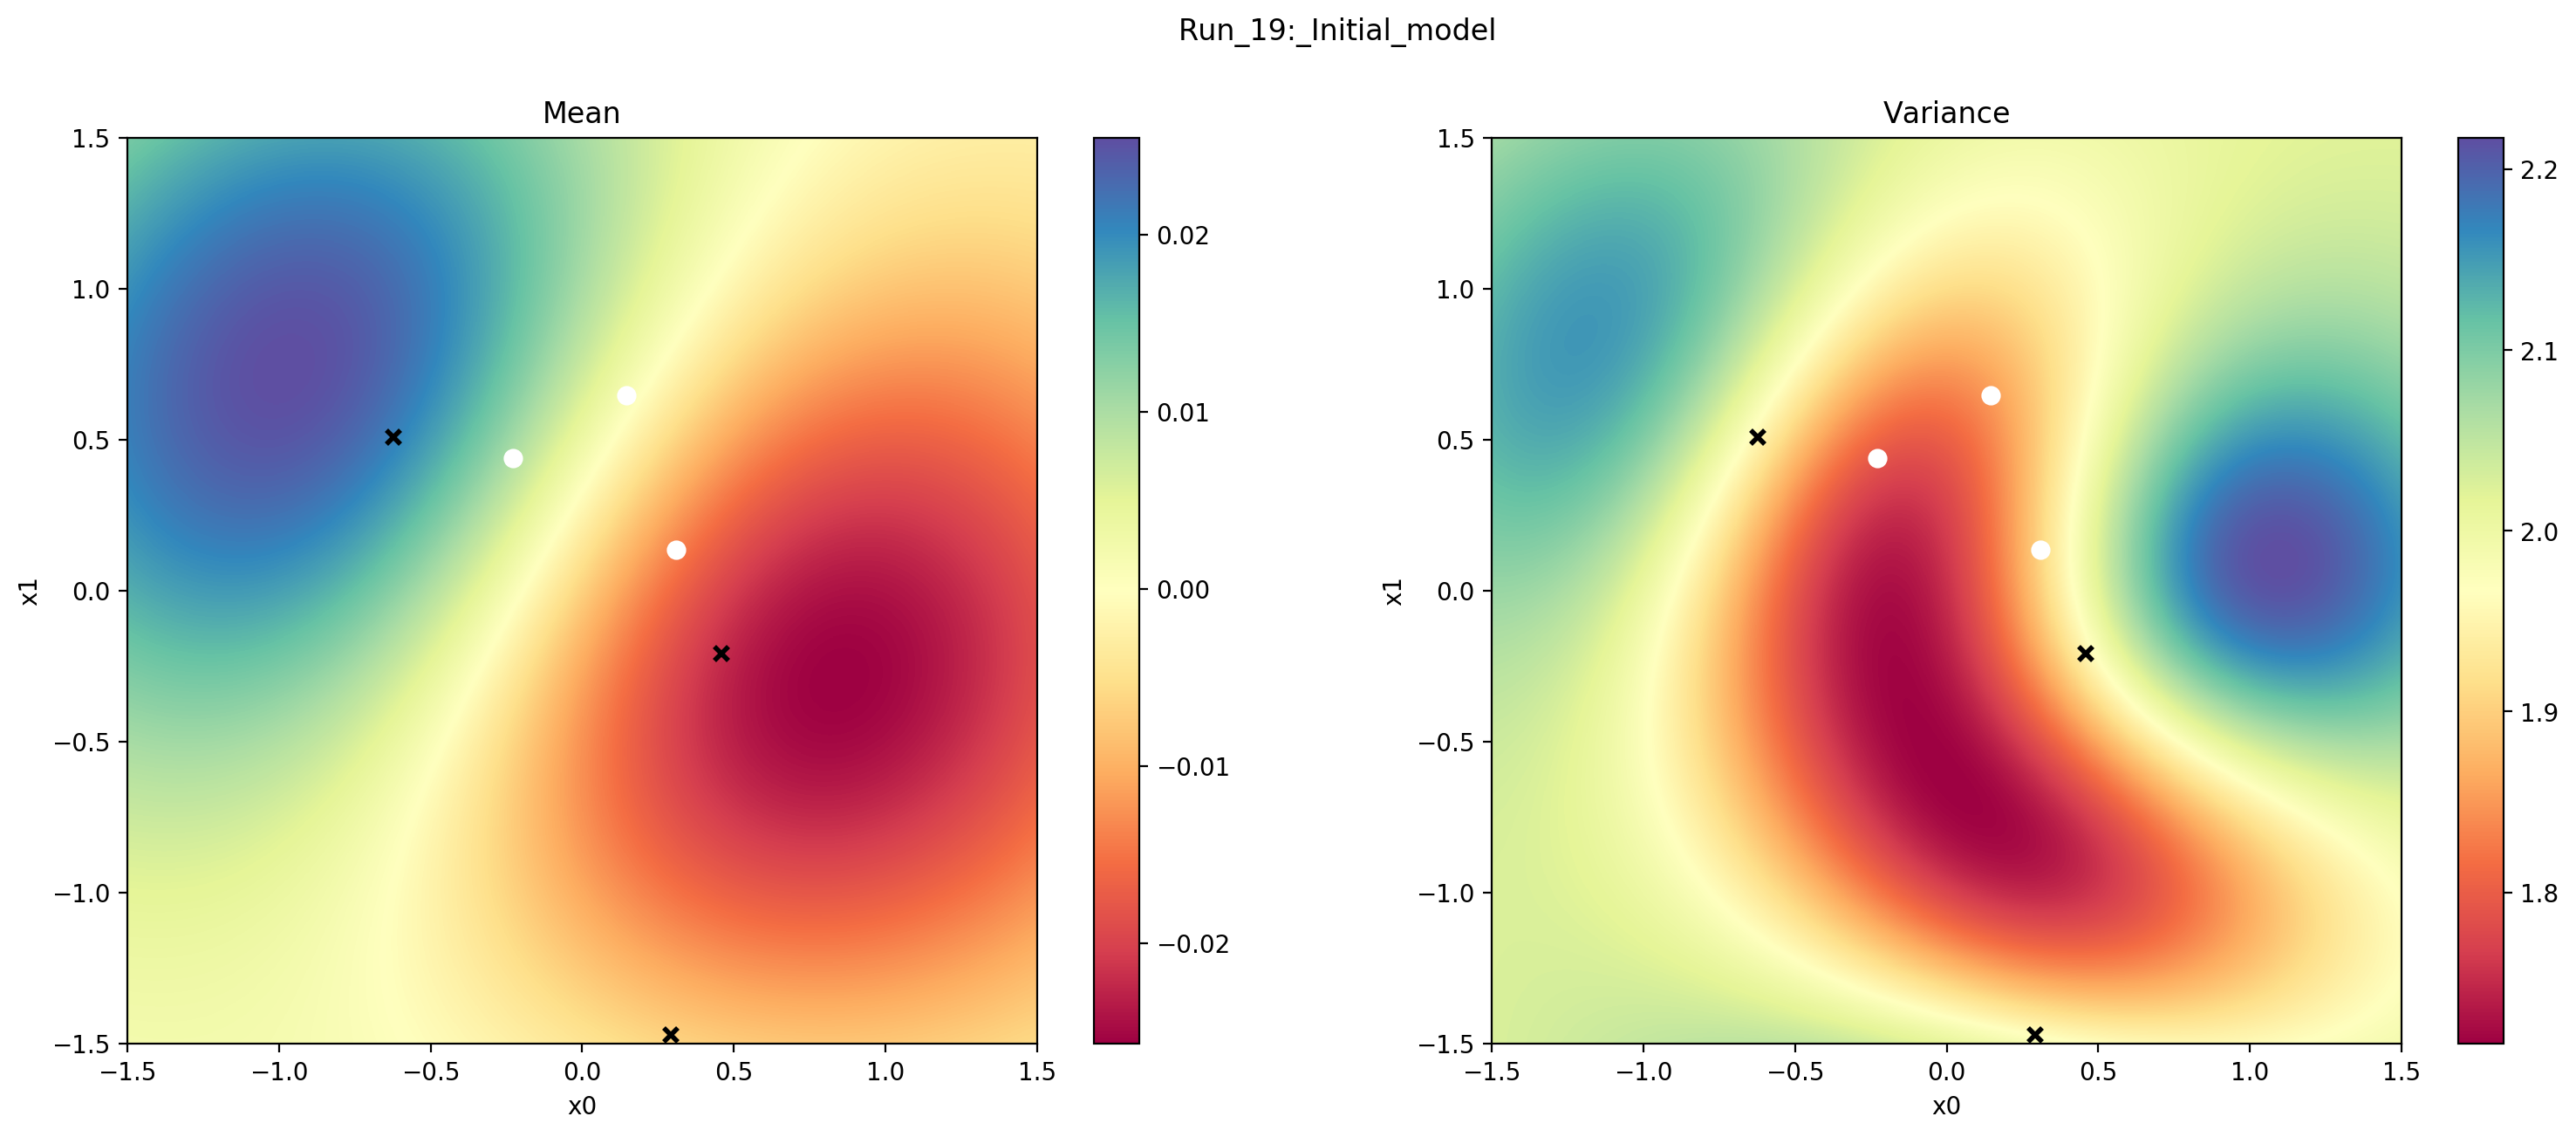

In [14]:
model, inputs, u_mean, inducing_vars = train_and_visualize(X, y, num_inducing_init, "Run_{}:_Initial_model".format(run))

In [17]:
1.0 / model.kernel.lengthscale

<tf.Tensor: shape=(2,), dtype=float64, numpy=array([1.01731054, 1.01794231])>

In [23]:
tf.random.normal(shape=(3, 3, 2),
                         mean=0.0,
                         stddev=1.0 / np.array([1, 1000000]),
                         dtype=tf.float64)

<tf.Tensor: shape=(3, 3, 2), dtype=float64, numpy=
array([[[ 2.26600267e-01, -5.18776259e-07],
        [-1.15789853e-01, -9.32936251e-07],
        [-1.10184083e+00, -2.33653821e-07]],

       [[ 2.25028362e-01, -6.08941188e-07],
        [ 4.37998960e-01,  1.37935161e-06],
        [-1.09054225e+00,  1.94567634e-07]],

       [[-6.44890370e-01, -6.20820616e-07],
        [-6.98786777e-01, -9.47583798e-07],
        [-1.16005607e+00,  7.45455856e-07]]])>

The following loops carry out the Bayesian optimization algorithm over a number of runs, with a fixed number of evaluations per run.

In [ ]:
for run in range(num_runs):
    print("Beginning run %s" % (run))
    
    X = init_vals[run]
    y = get_noisy_observation(X, objective)
    
    model, inputs, u_mean, inducing_vars = train_and_visualize(X, y, num_inducing_init, "Run_{}:_Initial_model".format(run))

    for evaluation in range(num_evals):
        print("Beginning evaluation %s" % (evaluation)) 

        # Sample possible next queries
        
        samples = PBO.acquisitions.pes.sample_inputs(inputs, num_samples, num_choices, objective_low, objective_high)

        # Sample maximizers
        print("Evaluation %s: Sampling maximizers" % (evaluation))
        maximizers = PBO.fourier_features.sample_maximizers(X=inducing_vars,
                                                            count=num_maximizers,
                                                            n_init=10,
                                                            D=100,
                                                            model=model,
                                                            min_val=objective_low,
                                                            max_val=objective_high)
        print(maximizers)

        # Calculate PES value I for each possible next query
        print("Evaluation %s: Calculating I" % (evaluation))
        I_vals = PBO.acquisitions.pes.I_batch(samples, maximizers, model)

        # Select query that maximizes I
        next_idx = np.argmax(I_vals)
        next_query = samples[next_idx]
        print("Evaluation %s: Next query is %s with I value of %s" % (evaluation, next_query, I_vals[next_idx]))

        X = np.concatenate([X, [next_query]])
        # Evaluate objective function
        y = np.concatenate([y, get_noisy_observation(np.expand_dims(next_query, axis=0), objective)], axis=0)
        
        print("Evaluation %s: Training model" % (evaluation))
        model, inputs, u_mean, inducing_vars = train_and_visualize(X, y, 
                                                                   num_inducing_init + evaluation + 1, 
                                                                   "Run_{}_Evaluation_{}".format(run, evaluation))

        best_guess_results[run, evaluation, :] = best_guess(model)

    X_results[run] = X
    y_results[run] = y

In [ ]:
pickle.dump((X_results, y_results, best_guess_results), open(results_dir + "Xybestguess.p", "wb"))

In [ ]:
def dist(x, y):
    """
    x and y have shape (..., input_dims)
    """
    return np.sqrt(np.sum((x - y) * (x - y), axis=-1))

In [ ]:
xx = uniform_grid(input_dims, num_discrete_per_dim, low=objective_low, high=objective_high)
global_min = xx[np.argmin(objective(xx))][0]

for i in range(best_guess_results.shape[0]):
    diff_from_min = dist(best_guess_results[i], global_min)
    
    x_axis = list(range(num_combs+1, num_combs+1+num_evals))
    plt.figure(figsize=(12, 6))
    plt.plot(x_axis, diff_from_min, 'kx', mew=2)
    plt.xticks(x_axis)
    plt.xlabel('Evaluations', fontsize=18)
    plt.ylabel('Best guess distance', fontsize=16)
    plt.title("Run %s" % i)
    plt.show()